In [1]:
%pylab inline

/Users/joleary/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from functools import reduce

import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.image as m_img

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager as font_manager

import csv

import scipy.ndimage.filters as filters
import scipy.signal as signal

# ALL DIVISION DEFAULTS TO FLOATING POINT DIVISION
from __future__ import division

In [3]:
# Load images into an array

images = []
height_images = []
texture_images = []

# '0-0' is ground truth
image_labels = ['c00', 'c05', 'c10', 'c15', 'c20', 'c25', 'c30', 'c35', \
                    'c40', 'c45', 'c50', 'c55']
height_image_labels = ['bh1mm', 'bh2mm', 'bh3mm', 'bh4mm', 'bh5mm', \
                          'bh6mm', 'bh7mm', 'bh8mm', 'bh9mm', 'bh10mm']
texture_image_labels = ['r2mm', 'r3mm', 'r4mm', 'r5mm']

for label in image_labels:
    image = m_img.imread('./concentrations/{}.png'.format(label))
    images.append(image)
    
for label in height_image_labels:
    image = m_img.imread('./base_heights/{}.png'.format(label))
    height_images.append(image)

for label in texture_image_labels:
    image = m_img.imread('./textures/{}.png'.format(label))
    texture_images.append(image)
    
naked_led_image = m_img.imread('./util_images/naked_led.png')
black_test_image = m_img.imread('./util_images/black_test.png')
white_test_image = m_img.imread('./util_images/white_test.png')
    
# For drawing rings around a center (see below)
X_CENTER_DEFAULT = 150
Y_CENTER_DEFAULT = 150

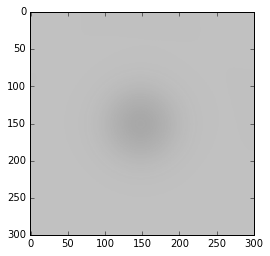

In [4]:
naked_led_image_smooth = filters.gaussian_filter(naked_led_image, 30)
imgplot = plt.imshow(naked_led_image_smooth)

In [5]:
def png_to_grayscale(img_png, normalize=False):
    """
    Takes an (m x n x 4)-shape matrix representing an m-by-n
    PNG image with 4 channels (R, G, B, A) and returns a channel-flattened
    (m x n)-shape matrix i.e. a grayscale matrix.
    
    Uses the ITU-R 601-2 luma transform:
    L = R * 299/1000 + G * 587/1000 + B * 114/1000
    """
    img_png = img_png[:, :, 0] * 299/1000 + img_png[:, :, 1] * 587/1000 \
        + img_png[:, :, 2] * 114/1000
    if normalize:
        return img_png / img_png.max()
    return img_png
    
def plot_3d_surface(img_png, stride=10):
    """
    Given a PNG as an array, plots a wireframe.
    """
    x_range = np.arange(img_png.shape[1])
    y_range = np.arange(img_png.shape[0])
    x_range, y_range = np.meshgrid(x_range, y_range)
    z = png_to_grayscale(img_png)
    stride = int(max(img_png.shape[0], img_png.shape[1]) / stride)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # ax.plot_wireframe(x_range, y_range, z, rstride=stride, cstride=stride)
    ax.plot_surface(x_range, y_range, z, rstride=stride, cstride=stride, cmap=cm.OrRd, linewidth=0.5)
    
def sample_ring(img_png, x_center, y_center, radius):
    """
    Uses the Midpoint Circle Algorithm to select pixel values RADIUS pixels
    away from center with x, y coordinates X_CENTER and Y_CENTER, respectively.
    The function returns the average luminosity from 0.0 to 1.0 of the pixels
    on the specified ring.
    """
    img_png = png_to_grayscale(img_png)
    x = radius
    y = 0
    err = 0
    total = 0
    count = 0
    try: 
        while (x >= y):
            total += img_png[x_center + x][y_center + y]
            total += img_png[x_center + x][y_center + y]
            total += img_png[x_center - x][y_center + y]
            total += img_png[x_center - x][y_center + y]
            total += img_png[x_center - x][y_center - y]
            total += img_png[x_center - x][y_center - y]
            total += img_png[x_center + x][y_center - y]
            total += img_png[x_center + x][y_center - y]
            count += 8

            y += 1
            err += 1 + 2 * y;
            if 2 * (err - x) + 1 > 0:
                x -= 1
                err += 1 - 2 * x
    except IndexError:
        print "Error: radius is too big for the image"
        return 0
     
    return total / count

In [6]:
sample_ring(images[0], X_CENTER_DEFAULT, Y_CENTER_DEFAULT, 5)

0.91584142670035362

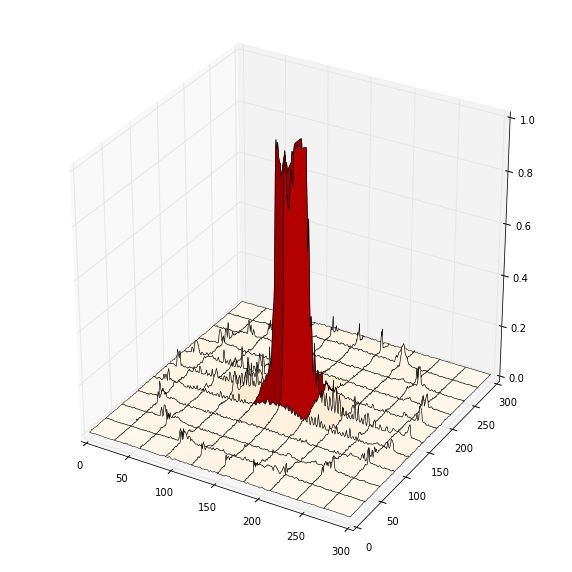

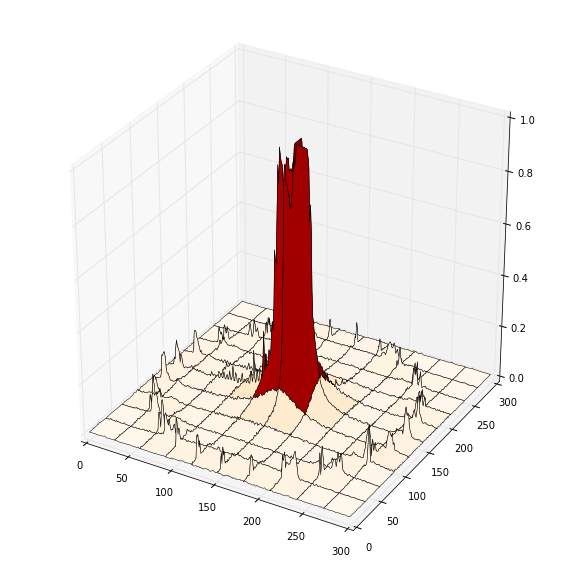

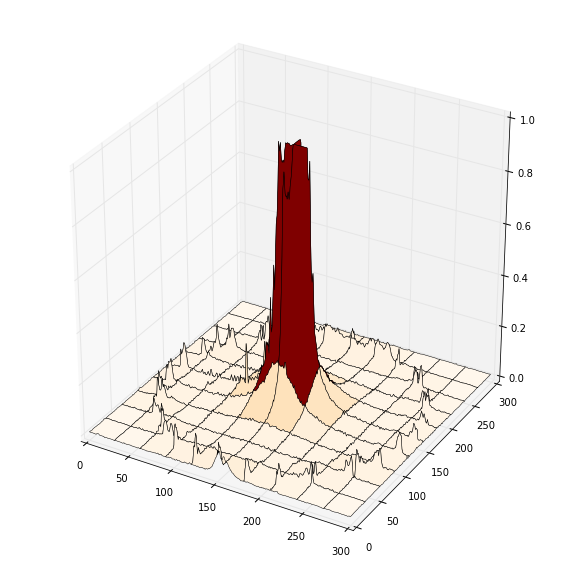

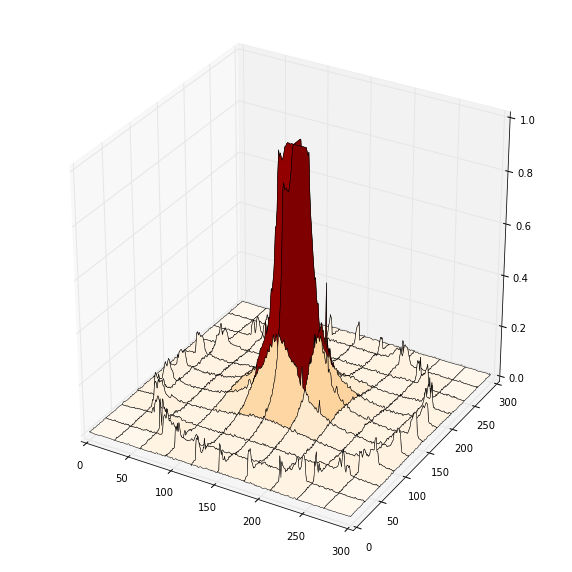

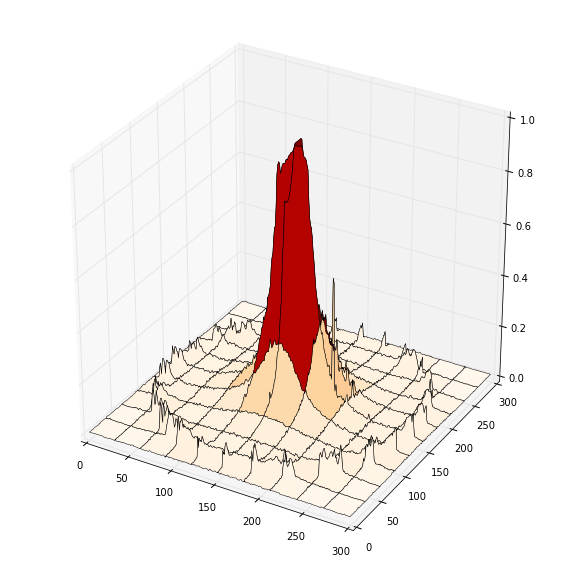

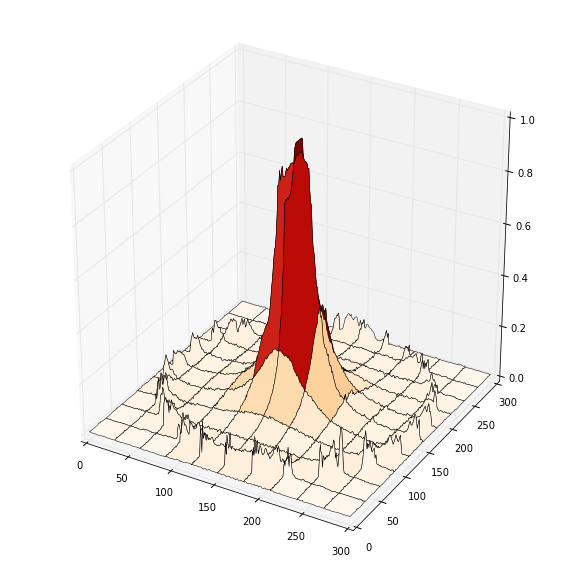

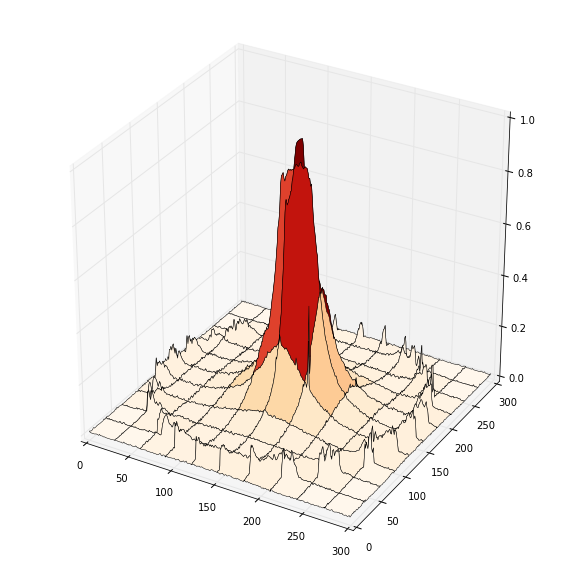

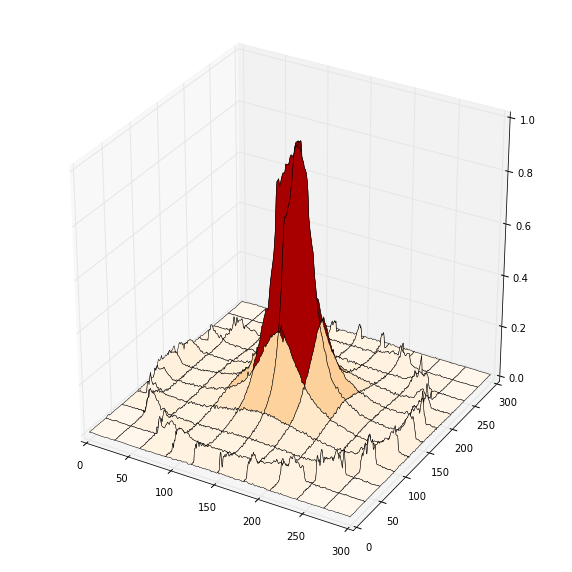

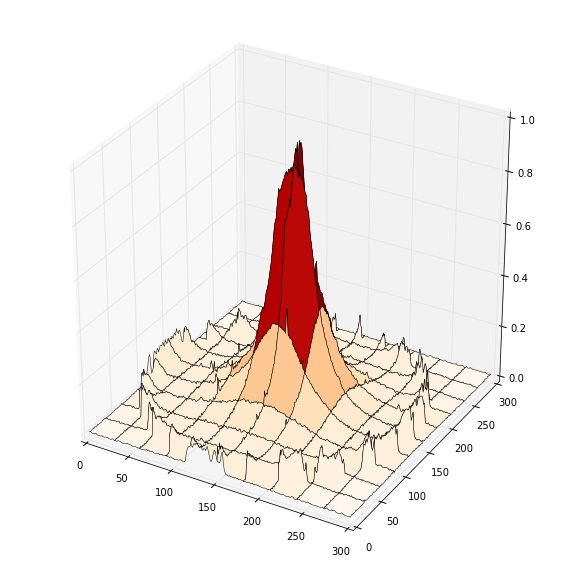

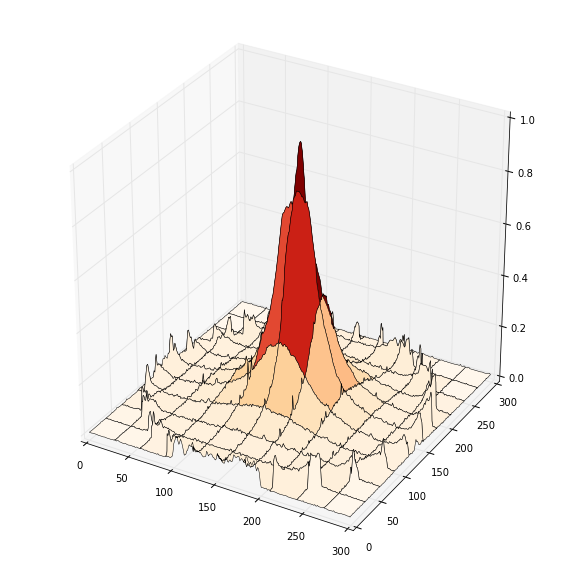

In [7]:
# Plot graphs
figsize(10, 10)
for image in height_images:
    plot_3d_surface(image)
    show()

### Slice Graphs

/Users/joleary/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


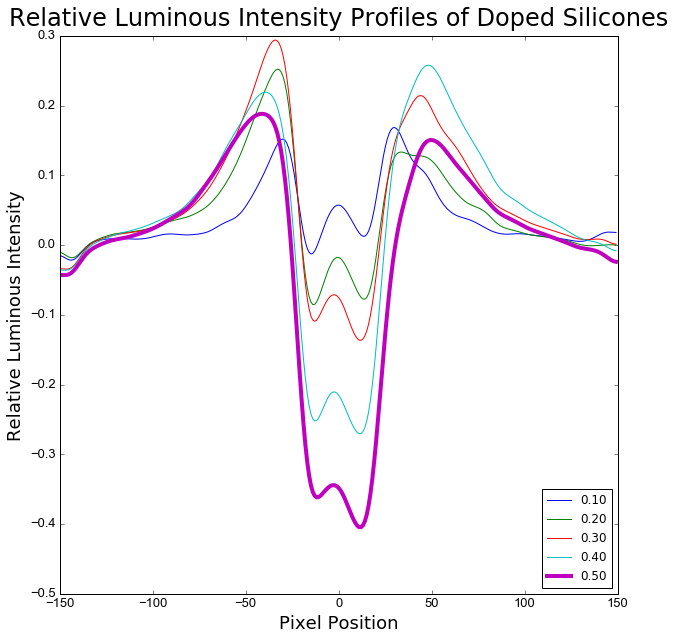

In [8]:
slice_c00 = png_to_grayscale(images[0])[X_CENTER_DEFAULT]
slice_c10 = png_to_grayscale(images[2])[X_CENTER_DEFAULT]
slice_c20 = png_to_grayscale(images[4])[X_CENTER_DEFAULT]
slice_c30 = png_to_grayscale(images[6])[X_CENTER_DEFAULT]
slice_c40 = png_to_grayscale(images[8])[X_CENTER_DEFAULT]
slice_c50 = png_to_grayscale(images[10], normalize=False)[X_CENTER_DEFAULT]
naked_led_slice = png_to_grayscale(naked_led_image)[X_CENTER_DEFAULT]
base_slice_3mm = png_to_grayscale(height_images[2])[X_CENTER_DEFAULT]
black_test_slice = png_to_grayscale(black_test_image, normalize=False)[X_CENTER_DEFAULT]
white_test_slice = png_to_grayscale(white_test_image, normalize=False)[X_CENTER_DEFAULT]
x_axis = np.arange(-150, 150)

# Smooth the slices
BLUR_FACTOR_CONCEN = 5
BLUR_FACTOR_BASE = 0
slice_c00 = filters.gaussian_filter(slice_c00, BLUR_FACTOR_CONCEN)
slice_c10 = filters.gaussian_filter(slice_c10, BLUR_FACTOR_CONCEN)
slice_c20 = filters.gaussian_filter(slice_c20, BLUR_FACTOR_CONCEN)
slice_c30 = filters.gaussian_filter(slice_c30, BLUR_FACTOR_CONCEN)
slice_c40 = filters.gaussian_filter(slice_c40, BLUR_FACTOR_CONCEN)
slice_c50 = filters.gaussian_filter(slice_c50, BLUR_FACTOR_CONCEN)
base_slice_3mm = filters.gaussian_filter(base_slice_3mm, BLUR_FACTOR_BASE)

# DRAW PLOTS
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Helvetica', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Helvetica', 'size':'18'}

# # Set the font properties (for use in legend)   
# font_path = 'C:\Windows\Fonts\Arial.ttf'
# font_prop = font_manager.FontProperties(fname=font_path, size=14)

# Defines ax variable by creating an empty plot
ax = plt.subplot()

# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

# x = np.linspace(0, 10)
# y = x + np.random.normal(x) # Just simulates some data

# plt.plot(x_axis, slice_c00 - naked_led_slice, label='0.00', lw=4)
plt.plot(x_axis, slice_c10 - slice_c00, label='0.10')
plt.plot(x_axis, slice_c20 - slice_c00, label='0.20')
plt.plot(x_axis, slice_c30 - slice_c00, label='0.30')
plt.plot(x_axis, slice_c40 - slice_c00, label='0.40')
plt.plot(x_axis, slice_c50 - slice_c00, label='0.50', lw=4)
# plt.plot(x_axis, white_test_slice, label='white', lw=4)
# plt.plot(x_axis, black_test_slice, label='black', lw=4)
# for image in images:
#     curr_slice = png_to_grayscale(image)[X_CENTER_DEFAULT]
#     plt.plot(x_axis, curr_slice)
plt.xlabel("Pixel Position", **axis_font)
plt.ylabel("Relative Luminous Intensity", **axis_font)
plt.title("Relative Luminous Intensity Profiles of Doped Silicones", **title_font)
plt.legend(loc='lower right', numpoints=1)

figsize(10, 10)
plt.show()

In [9]:
# # Note: if you add/subtract radii, adjust the cell below for CSV creation
# radii = [25, 50, 75]
# brightnesses = np.zeros(len(images), len(radii))
# # Ugly for-loops, sorry
# for image in enumerate(images):
#     for radius in enumerate(radii):
#         brightnesses[image[0]][radius[0]]

In [10]:
png_to_grayscale(images[0]).shape

(300, 300)

# Base Heights

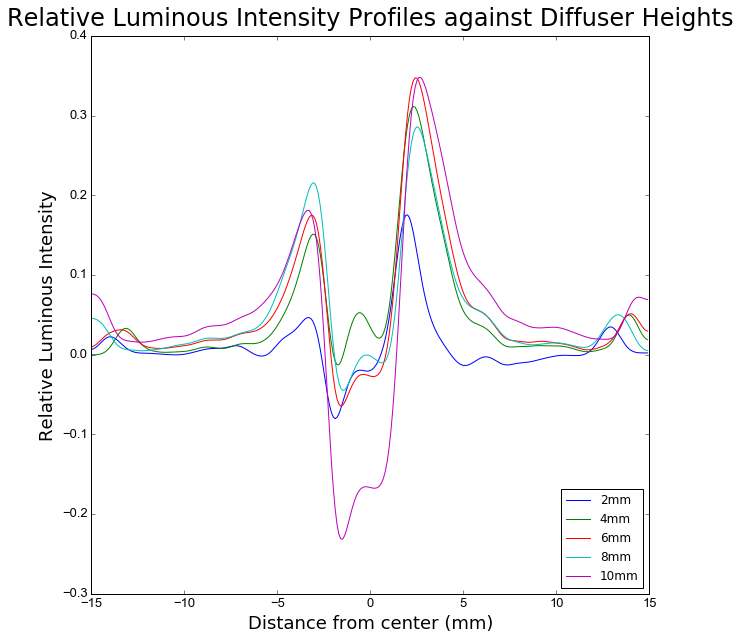

In [11]:
base_slice_1mm = png_to_grayscale(height_images[0])[X_CENTER_DEFAULT]
base_slice_2mm = png_to_grayscale(height_images[1])[X_CENTER_DEFAULT]
base_slice_4mm = png_to_grayscale(height_images[3])[X_CENTER_DEFAULT]
base_slice_6mm = png_to_grayscale(height_images[5])[X_CENTER_DEFAULT]
base_slice_8mm = png_to_grayscale(height_images[7])[X_CENTER_DEFAULT]
base_slice_10mm = png_to_grayscale(height_images[9])[X_CENTER_DEFAULT]
x_axis = np.arange(-15, 15, step=0.1)

# Smooth the slices
BLUR_FACTOR_BASE = 5
base_slice_1mm = filters.gaussian_filter(base_slice_1mm, BLUR_FACTOR_BASE)
base_slice_2mm = filters.gaussian_filter(base_slice_2mm, BLUR_FACTOR_BASE)
base_slice_4mm = filters.gaussian_filter(base_slice_4mm, BLUR_FACTOR_BASE)
base_slice_6mm = filters.gaussian_filter(base_slice_6mm, BLUR_FACTOR_BASE)
base_slice_8mm = filters.gaussian_filter(base_slice_8mm, BLUR_FACTOR_BASE)
base_slice_10mm = filters.gaussian_filter(base_slice_10mm, BLUR_FACTOR_BASE)
naked_led_slice = filters.gaussian_filter(naked_led_slice, BLUR_FACTOR_BASE)

# DRAW PLOTS
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Helvetica', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Helvetica', 'size':'18'}

# # Set the font properties (for use in legend)   
# font_path = 'C:\Windows\Fonts\Arial.ttf'
# font_prop = font_manager.FontProperties(fname=font_path, size=14)

# Defines ax variable by creating an empty plot
ax = plt.subplot()

# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

# x = np.linspace(0, 10)
# y = x + np.random.normal(x) # Just simulates some data

# plt.plot(x_axis, base_slice_1mm - naked_led_slice, label='1mm')
plt.plot(x_axis, base_slice_2mm - base_slice_1mm, label='2mm')
plt.plot(x_axis, base_slice_4mm - base_slice_1mm, label='4mm')
plt.plot(x_axis, base_slice_6mm - base_slice_1mm, label='6mm')
plt.plot(x_axis, base_slice_8mm - base_slice_1mm, label='8mm')
plt.plot(x_axis, base_slice_10mm - base_slice_1mm, label='10mm')
# plt.plot(x_axis, naked_led_slice, label='naked', lw=4)
# for image in images:
#     curr_slice = png_to_grayscale(image)[X_CENTER_DEFAULT]
#     plt.plot(x_axis, curr_slice)
plt.xlabel("Distance from center (mm)", **axis_font)
plt.ylabel("Relative Luminous Intensity", **axis_font)
plt.title("Relative Luminous Intensity Profiles against Diffuser Heights", **title_font)
plt.legend(loc='lower right', numpoints=1)

figsize(10, 10)
plt.show()

# Textures

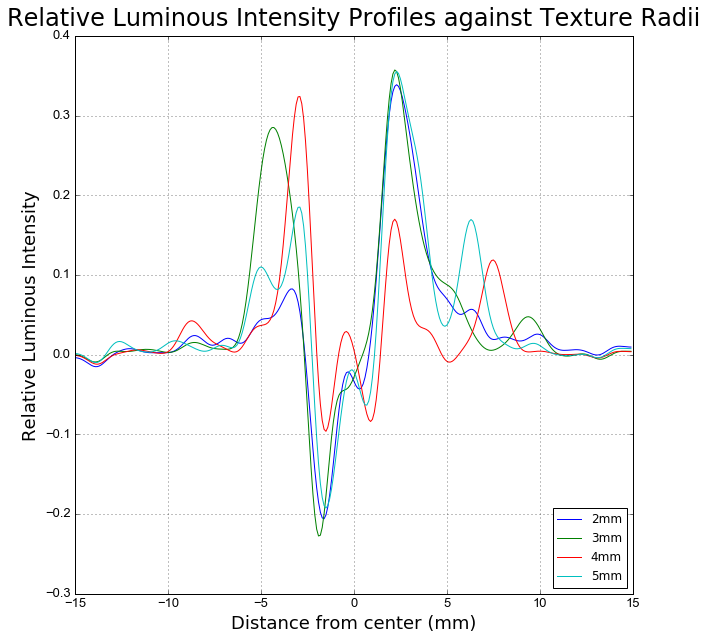

In [13]:
texture_slice_2mm = png_to_grayscale(texture_images[0])[X_CENTER_DEFAULT]
texture_slice_3mm = png_to_grayscale(texture_images[1])[X_CENTER_DEFAULT]
texture_slice_4mm = png_to_grayscale(texture_images[2])[X_CENTER_DEFAULT]
texture_slice_5mm = png_to_grayscale(texture_images[3])[X_CENTER_DEFAULT]
base_slice_1mm = png_to_grayscale(height_images[0])[X_CENTER_DEFAULT]
x_axis = np.arange(-15, 15, step=0.1)

# Smooth the slices
BLUR_FACTOR_TEXTURE = 5
texture_slice_2mm = filters.gaussian_filter(texture_slice_2mm, BLUR_FACTOR_TEXTURE)
texture_slice_3mm = filters.gaussian_filter(texture_slice_3mm, BLUR_FACTOR_TEXTURE)
texture_slice_4mm = filters.gaussian_filter(texture_slice_4mm, BLUR_FACTOR_TEXTURE)
texture_slice_5mm = filters.gaussian_filter(texture_slice_5mm, BLUR_FACTOR_TEXTURE)
base_slice_1mm = filters.gaussian_filter(base_slice_1mm, BLUR_FACTOR_TEXTURE)

# DRAW PLOTS
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Helvetica', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Helvetica', 'size':'18'}

# # Set the font properties (for use in legend)   
# font_path = 'C:\Windows\Fonts\Arial.ttf'
# font_prop = font_manager.FontProperties(fname=font_path, size=14)

# Defines ax variable by creating an empty plot
ax = plt.subplot()

# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

# x = np.linspace(0, 10)
# y = x + np.random.normal(x) # Just simulates some data

# plt.plot(x_axis, base_slice_1mm - naked_led_slice, label='1mm')
plt.plot(x_axis, texture_slice_2mm - base_slice_1mm, label='2mm')
plt.plot(x_axis, texture_slice_3mm - base_slice_1mm, label='3mm')
plt.plot(x_axis, texture_slice_4mm - base_slice_1mm, label='4mm')
plt.plot(x_axis, texture_slice_5mm - base_slice_1mm, label='5mm')
# plt.plot(x_axis, naked_led_slice, label='naked', lw=4)
# for image in images:
#     curr_slice = png_to_grayscale(image)[X_CENTER_DEFAULT]
#     plt.plot(x_axis, curr_slice)
plt.xlabel("Distance from center (mm)", **axis_font)
plt.ylabel("Relative Luminous Intensity", **axis_font)
plt.title("Relative Luminous Intensity Profiles against Texture Radii", **title_font)
plt.legend(loc='lower right', numpoints=1)
plt.grid(True)

figsize(10, 10)
plt.show()

# Plotting Theoretical Values

### Calculate the BRDF of the LED

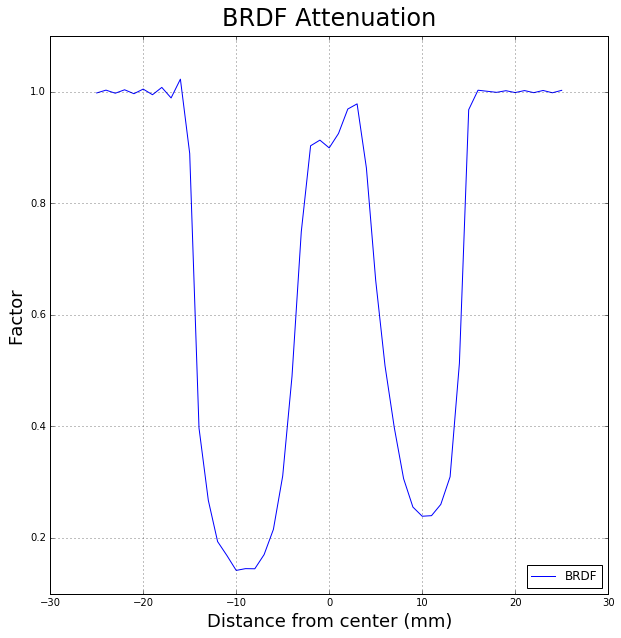

In [69]:
BLUR_FACTOR_CONCEN = 5
slice_c00 = png_to_grayscale(images[0])[X_CENTER_DEFAULT]
slice_c00 = filters.gaussian_filter(slice_c00, BLUR_FACTOR_CONCEN)

# Supersample, smooth, downsample theoretical model
UPSAMPLE_FACTOR = 10
th_slice_c00 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 282, 320, 364, 411, 461, 513, 566, 615, 659, 695, 719, 726, 719, 697, 662, 618, 568, 517, 464, 414, 366, 323, 284, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
kernel_mean_81 = np.full((9, 9), 1/81)
th_slice_c00 = signal.resample(th_slice_c00, len(th_slice_c00) * UPSAMPLE_FACTOR)
th_slice_c00 = filters.convolve(th_slice_c00, kernel_mean_81.flatten())
th_slice_c00 = signal.resample(th_slice_c00, 300)
th_slice_c00 *= 1.0 / max(th_slice_c00)

EPSILON = 0.000001
brdf = np.copy(slice_c00)
brdf /= (np.clip(th_slice_c00, a_min=EPSILON, a_max=None))
brdf = np.clip(brdf, a_min=0.0, a_max=1.0)
brdf_51 = signal.resample(brdf, 51)
x_axis_51 = np.arange(-25, 26, step=1)
plt.plot(x_axis_51, brdf_51, label="BRDF")

plt.xlabel("Distance from center (mm)", **axis_font)
plt.ylabel("Factor", **axis_font)
plt.title("BRDF Attenuation", **title_font)
plt.legend(loc='lower right', numpoints=1)
plt.grid(True)

figsize(10, 10)
plt.show()

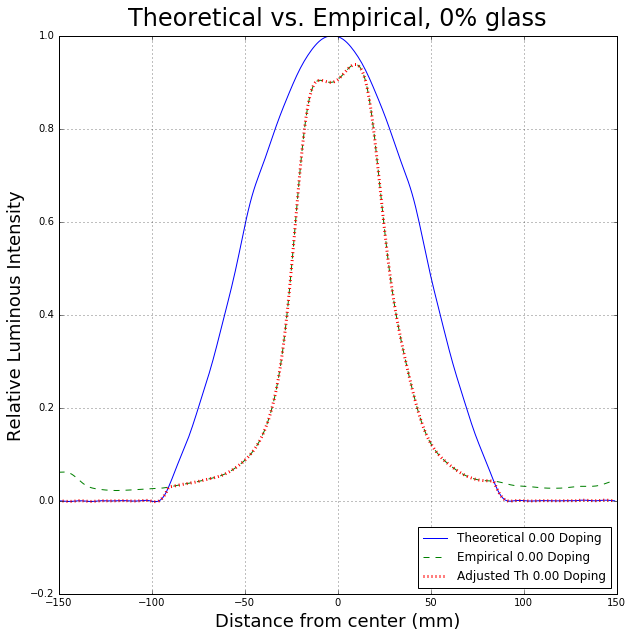

In [70]:
# Let's try it out!

aj_slice_c00 = th_slice_c00 * brdf

plt.plot(x_axis, th_slice_c00, label='Theoretical 0.00 Doping')
plt.plot(x_axis, slice_c00, label='Empirical 0.00 Doping', linestyle='--')
# plt.plot(x_axis, slice_c10, label='Empirical 0.10 Doping')
plt.plot(x_axis, aj_slice_c00, label='Adjusted Th 0.00 Doping', linestyle=':', linewidth=3)

plt.xlabel("Distance from center (mm)", **axis_font)
plt.ylabel("Relative Luminous Intensity", **axis_font)
plt.title("Theoretical vs. Empirical, 0% glass", **title_font)
plt.legend(loc='lower right', numpoints=1)
plt.grid(True)

figsize(10, 10)
plt.show()

### Now actually plot the values

In [83]:
UPSAMPLE_FACTOR = 10

th_vals_raw = np.genfromtxt('./theoretical_values.csv', delimiter=',')
th_vals = np.zeros((th_vals_raw.shape[0] , 300));
for i in range(th_vals_raw.shape[0]):
    row = th_vals_raw[i]
    tmp_signal = signal.resample(row, len(row) * UPSAMPLE_FACTOR)
    tmp_signal = filters.convolve(tmp_signal, kernel_mean_81.flatten())
    tmp_signal = signal.resample(tmp_signal, 300)
    tmp_signal *= brdf
    th_vals[i] = tmp_signal
    
th_vals /= np.ndarray.max(th_vals)

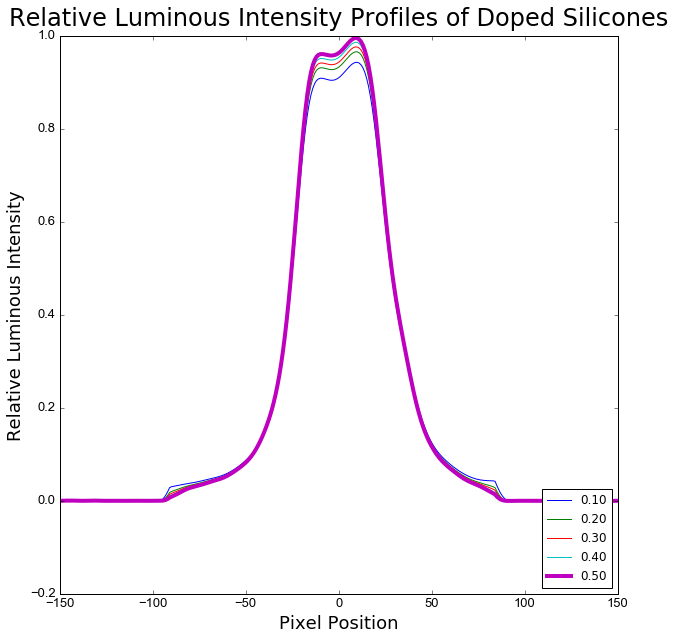

In [85]:
th_slice_c00 = th_vals[0]
th_slice_c10 = th_vals[2]
th_slice_c20 = th_vals[4]
th_slice_c30 = th_vals[6]
th_slice_c40 = th_vals[8]
th_slice_c50 = th_vals[10]
x_axis = np.arange(-150, 150)

# DRAW PLOTS
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Helvetica', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Helvetica', 'size':'18'}

# # Set the font properties (for use in legend)   
# font_path = 'C:\Windows\Fonts\Arial.ttf'
# font_prop = font_manager.FontProperties(fname=font_path, size=14)

# Defines ax variable by creating an empty plot
ax = plt.subplot()

# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

# x = np.linspace(0, 10)
# y = x + np.random.normal(x) # Just simulates some data

# plt.plot(x_axis, slice_c00 - naked_led_slice, label='0.00', lw=4)
plt.plot(x_axis, th_slice_c00, label='0.10')
plt.plot(x_axis, th_slice_c20, label='0.20')
plt.plot(x_axis, th_slice_c30, label='0.30')
plt.plot(x_axis, th_slice_c40, label='0.40')
plt.plot(x_axis, th_slice_c50, label='0.50', lw=4)

# plt.plot(x_axis, slice_c00, label='Em 0.10')
# plt.plot(x_axis, slice_c50, label='Em 0.50', lw=4)

plt.xlabel("Pixel Position", **axis_font)
plt.ylabel("Relative Luminous Intensity", **axis_font)
plt.title("Relative Luminous Intensity Profiles of Doped Silicones", **title_font)
plt.legend(loc='lower right', numpoints=1)

figsize(10, 10)
plt.show()

# Export Options

In [11]:
radius = 35
densities = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
with open("lum_vs_density_radius_{}.csv".format(radius), "w+") as file: 
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(['Density','Brightness'])
    for i in range(0, len(images) - 1):
        writer.writerow([densities[i], sample_ring(images[i], X_CENTER_DEFAULT, Y_CENTER_DEFAULT, radius)])

In [11]:
# Assuming a slice across the y-axix i.e. a "north-to-south" cut
density_index = 10
for density in densities:
    with open("slices_density_{}.csv".format(density), "w+") as file:
        slice_image = png_to_grayscale(images[density_index])[X_CENTER_DEFAULT]
        writer = csv.writer(file, lineterminator='\n')
        writer.writerow(['Y-value','Brightness'])
        for i in range(0, slice_image.shape[0]):
            writer.writerow([i, slice_image[i]])